In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet50
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from shapley.transform import ThresholdTransform, AddNoise,DetachWhite
import torch
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torchvision.datasets import ImageFolder

/data/jong980812/anaconda3/envs/asd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torchvision.models as models
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn

model=models.efficientnet_b1(pretrained=True)
model.classifier[1] = torch.nn.Linear(1280, 2)
finetune='/data/jong980812/project/mae/result_after_shapley/drawer/binary_240_0.98_224168/OUT/01/checkpoint-29.pth'
model.classifier = nn.Identity()
checkpoint = torch.load(finetune, map_location='cpu')
print("Load pre-trained checkpoint from: %s" % finetune)
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()
msg = model.load_state_dict(checkpoint_model, strict=False)
print(msg)
model.eval()
def set_conv_padding_mode(model, padding_mode='zeros'):
  for name, layer in model.named_modules():
      if isinstance(layer, torch.nn.Conv2d):
          layer.padding_mode = padding_mode
set_conv_padding_mode(model,padding_mode='zeros')

transform=transforms.Compose([
    transforms.Resize((224,224)),
    # transforms.RandomCrop((224,224)),
    # transforms.Grayscale(3),
    # transforms.RandomInvert(1),
    transforms.ToTensor(),
    ThresholdTransform(240),
    # AddNoise(50)
    transforms.Normalize(mean=[0.98, 0.98, 0.98],
                            std=[0.065,0.065,0.065])
    ])
dataset = datasets.ImageFolder('/local_datasets/ai_hub/ai_hub_sketch_drawer/01/val/', transform=transform)
model.to('cuda')
dataloader =DataLoader(dataset,500,True)
feature_map= nn.Sequential(*(list(model.children())[0][:9])) # input to penultimate layer


Load pre-trained checkpoint from: /data/jong980812/project/mae/result_after_shapley/drawer/binary_240_0.98_224168/OUT/01/checkpoint-29.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['classifier.1.weight', 'classifier.1.bias'])


In [3]:
features =[]
labels = []
model.eval()


with torch.no_grad():
    for img, label in dataloader:
        img = img.to('cuda')
        feature = model(img)
        features.append(feature.cpu())
        labels.append(label.cpu())
features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()



In [ ]:
labels


In [ ]:
labels.shape

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
embedded_features = tsne.fit_transform(features)

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(embedded_features[:, 0], embedded_features[:, 1], c=labels,cmap='bwr', alpha=0.5)
plt.colorbar()
plt.title('t-SNE Visualization of Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

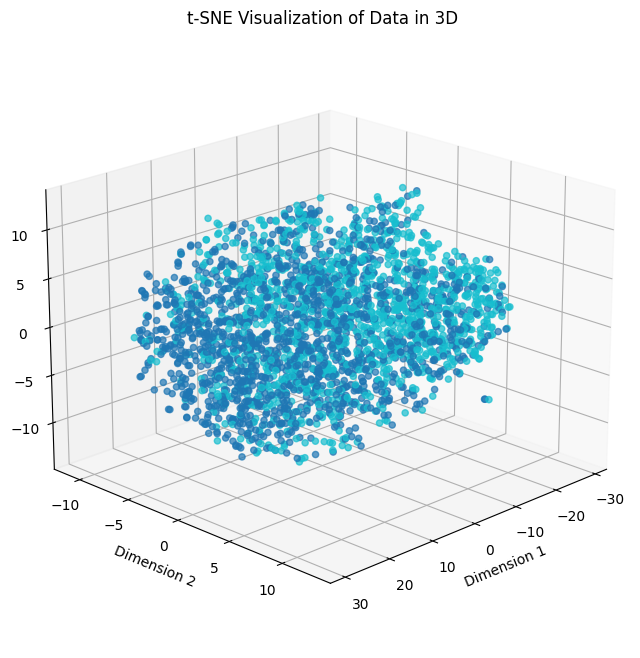

In [5]:
tsne = TSNE(n_components=3, random_state=0)
embedded_features = tsne.fit_transform(features)

# 3D 시각화


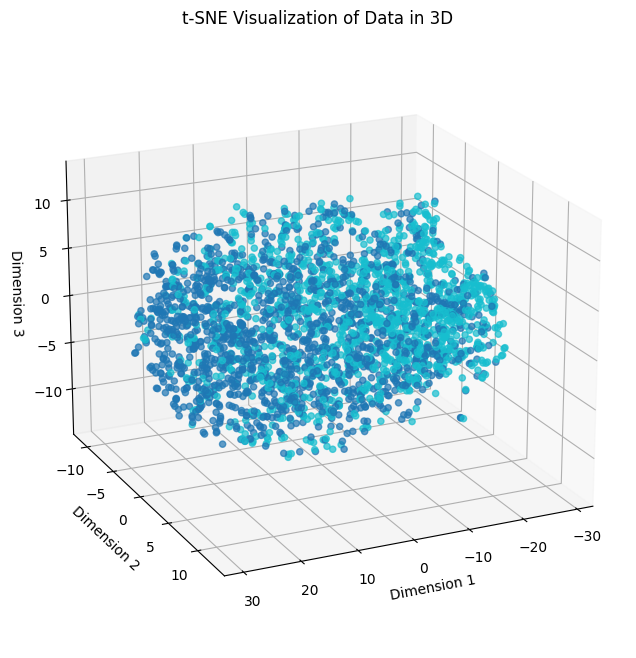

In [31]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# 그래프에 데이터 포인트 추가
scatter = ax.scatter(embedded_features[:, 0], embedded_features[:, 1], embedded_features[:, 2], c=labels, cmap='tab10', alpha=0.7)

# 그래프 축 레이블 및 제목 설정
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.title('t-SNE Visualization of Data in 3D')
ax.view_init(elev=20, azim=65,) 

plt.show()